In [133]:
import subprocess
from random import random, randint
from nfa_lib import NFA, random_matrix_for_nfa, count_nfa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm as tqdm
import pandas as pd
sns.set(rc={"figure.figsize": (14,10)})

In [166]:
def random_run():
    n_states = randint(2, 4)
    sparsity = round(random() / 2 + 0.5, 2)
    n_initial = randint(1, n_states)
    n_final = randint(1, n_states)
    string_length = randint(12, 14)
    epsilon = round(random() * 4.5 + 0.5, 1) # epsilon \in [0.5, 5]
    kappa_multiple = 1
    phi_multiple = round(2 ** (4 + random() * 6)) # phi_multiple \in [1, 64]
    
    rand_matrix = random_matrix_for_nfa(n_states=n_states, sparsity=sparsity, n_initial=n_initial, n_final=n_final)
    rand_nfa = NFA.from_random_matrix(rand_matrix)
    cpp_input = f"{string_length} {epsilon} {kappa_multiple} {phi_multiple}\n" + rand_nfa.to_text()
    result = subprocess.run(["timeout", "10", "./cpp/main"], 
                            stdout=subprocess.PIPE, 
                            input=cpp_input,
                            encoding="utf-8")
    res_dict = {}
    if result.returncode == 0:
        invalid = False
        for line in result.stdout.split("\n"):
            if "Got 0 when" in line or "Empty NFA" in line:
                invalid = True
                break
            l_split = line.split()
            if len(l_split) == 2:
                k, v = l_split
                res_dict[k] = float(v) if "." in v else int(v)
        if not invalid:
            res_dict["n_states"] = len(rand_nfa.states)
            res_dict["sparsity"] = sparsity
            res_dict["str_repr"] = cpp_input
            res_dict["string_len"] = string_length
            res_dict["epsilon"] = epsilon
            res_dict["kappa_multiple"] = kappa_multiple
            res_dict["phi_multiple"] = phi_multiple
        
    return rand_nfa, res_dict

In [189]:
rand_nfa, res_dict = random_run()
res_dict

{'retries_per_sample': 449148,
 'sample_size': 669,
 'sample_misses': 0,
 'sample_hits': 28098,
 'miss_ratio': 0,
 'bruteforce': 4409,
 'bruteforce_time': 33,
 'estimation': 4867.27,
 'estimation_time': 260,
 'n_states': 3,
 'sparsity': 0.72,
 'str_repr': '14 0.9 1 971\n3 2 8\n0 2 3\n1 0 0\n1 1 1\n0 1\n0 0 3\n0 0 2\n0 1 0\n0 1 3\n2 0 3\n2 0 2\n3 0 2\n3 1 3',
 'string_len': 14,
 'epsilon': 0.9,
 'kappa_multiple': 1,
 'phi_multiple': 971}

In [190]:
print('14 0.9 1 971\n3 2 8\n0 2 3\n1 0 0\n1 1 1\n0 1\n0 0 3\n0 0 2\n0 1 0\n0 1 3\n2 0 3\n2 0 2\n3 0 2\n3 1 3')

14 0.9 1 971
3 2 8
0 2 3
1 0 0
1 1 1
0 1
0 0 3
0 0 2
0 1 0
0 1 3
2 0 3
2 0 2
3 0 2
3 1 3


In [162]:
%%time
# cpp_input = res_dict["str_repr"]
ests = []

for phi in tqdm([25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]):
    eps = round(2/phi, 5)
    cpp_input = f'6 {eps} 1 {phi}\n4 2 16\n0 1 2 3\n0 1 0 0\n1 1 1 1\n0 1\n0 0 0\n0 1 3\n0 1 2\n1 0 0\n1 0 1\n1 1 3\n1 1 2\n2 0 0\n2 0 1\n2 0 2\n2 1 2\n3 0 0\n3 0 2\n3 1 1\n3 1 3\n3 1 2'
    for i in range(20):
        result = subprocess.run(["timeout", "300", "./cpp/main"], 
                                    stdout=subprocess.PIPE, 
                                    input=cpp_input,
                                    encoding="utf-8")
        res_dict2 = {}
        if result.returncode == 0:
            invalid = False
            for line in result.stdout.split("\n"):
                if "Got 0 when" in line or "Empty NFA" in line:
                    invalid = True
                    break
                l_split = line.split()
                if len(l_split) == 2:
                    k, v = l_split
                    res_dict2[k] = float(v) if "." in v else int(v)
        ests.append((phi, res_dict2["estimation"]))

100%|███████████████████████████████████████████| 14/14 [10:33<00:00, 45.26s/it]

CPU times: user 166 ms, sys: 1.04 s, total: 1.21 s
Wall time: 10min 33s


In [163]:
df = pd.DataFrame(ests, columns=["phi", "est"])

In [164]:
df["rmse"] = ((df.est - res_dict["bruteforce"])**2)**0.5

<AxesSubplot:xlabel='phi', ylabel='rmse'>

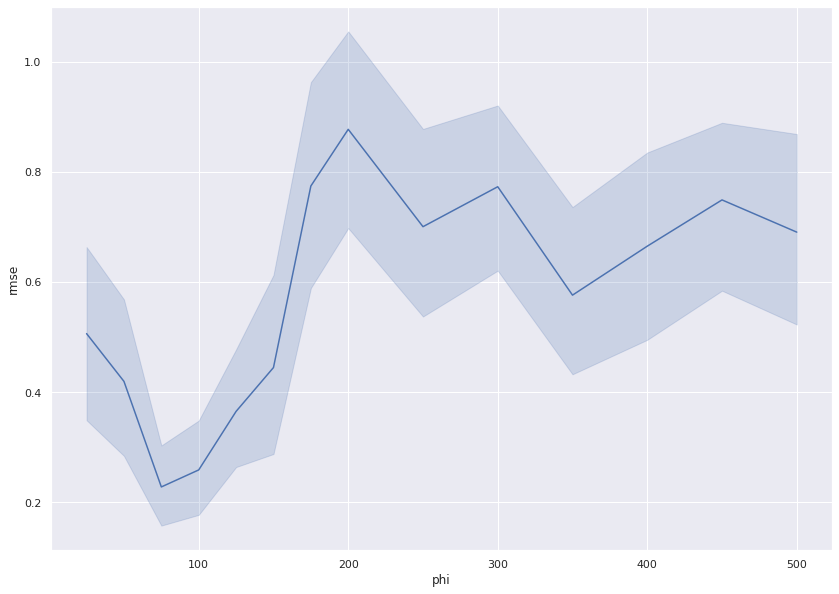

In [165]:
sns.lineplot(data=df, x="phi", y="rmse")


In [66]:
%%time
ests2 = []
for i in range(20):
    ests2.append(count_nfa(rand_nfa, 5)[0])

Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 57, '1': 53}), ('2', 1): Counter({'0': 58, '1': 52})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 57, '1': 53}), ('2', 1): Counter({'0': 58, '1': 52}), ('0', 2): Counter({'10': 58, '00': 52}), ('1', 2): Counter({'11': 61, '01': 49}), ('3', 2): Counter({'01': 30, '10': 30, '

Sample hits: 1980
Sample misses: 290039
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 59, '0': 51}), ('2', 1): Counter({'1': 58, '0': 52})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 59, '0': 51}), ('2', 1): Counter({'1': 58, '0': 52}), ('0', 2): Counter({'10': 57, '00': 53}), ('1', 2): Counter({'01': 56, '11': 54}), 

Sample hits: 1980
Sample misses: 302535
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 58, '0': 52}), ('2', 1): Counter({'0': 60, '1': 50})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 58, '0': 52}), ('2', 1): Counter({'0': 60, '1': 50}), ('0', 2): Counter({'00': 58, '10': 52}), ('1', 2): Counter({'01': 55, '11': 55}), 

Sample hits: 1980
Sample misses: 288266
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 64, '1': 46}), ('2', 1): Counter({'1': 57, '0': 53})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 64, '1': 46}), ('2', 1): Counter({'1': 57, '0': 53}), ('0', 2): Counter({'10': 56, '00': 54}), ('1', 2): Counter({'01': 62, '11': 48}), 

Sample hits: 1980
Sample misses: 302486
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 59, '0': 51}), ('2', 1): Counter({'1': 60, '0': 50})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 59, '0': 51}), ('2', 1): Counter({'1': 60, '0': 50}), ('0', 2): Counter({'00': 58, '10': 52}), ('1', 2): Counter({'11': 60, '01': 50}), 

Sample hits: 1980
Sample misses: 284882
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 60, '0': 50}), ('2', 1): Counter({'0': 56, '1': 54})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 60, '0': 50}), ('2', 1): Counter({'0': 56, '1': 54}), ('0', 2): Counter({'00': 68, '10': 42}), ('1', 2): Counter({'11': 58, '01': 52}), 

Sample hits: 1980
Sample misses: 295149
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 60, '1': 50}), ('2', 1): Counter({'1': 61, '0': 49})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 60, '1': 50}), ('2', 1): Counter({'1': 61, '0': 49}), ('0', 2): Counter({'10': 63, '00': 47}), ('1', 2): Counter({'11': 57, '01': 53}), 

Sample hits: 1980
Sample misses: 287603
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 56, '1': 54}), ('2', 1): Counter({'0': 62, '1': 48})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'0': 56, '1': 54}), ('2', 1): Counter({'0': 62, '1': 48}), ('0', 2): Counter({'00': 70, '10': 40}), ('1', 2): Counter({'11': 57, '01': 53}), 

Sample hits: 1980
Sample misses: 301825
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 68, '0': 42}), ('2', 1): Counter({'0': 56, '1': 54})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 68, '0': 42}), ('2', 1): Counter({'0': 56, '1': 54}), ('0', 2): Counter({'00': 56, '10': 54}), ('1', 2): Counter({'11': 57, '01': 53}), 

Sample hits: 1980
Sample misses: 286293
Retries per sample 332127
Sample size 110
1 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 60, '0': 50}), ('2', 1): Counter({'1': 61, '0': 49})}) {('1', 0): 1, ('3', 0): 1, ('2', 0): 1, ('0', 0): 1, ('0', 1): 1.0, ('1', 1): 1, ('3', 1): 2.0, ('2', 1): 2.0}
3 defaultdict(<class 'collections.Counter'>, {('1', 0): {'': 110}, ('3', 0): {'': 110}, ('2', 0): {'': 110}, ('0', 0): {'': 110}, ('0', 1): Counter({'0': 110}), ('1', 1): Counter({'1': 110}), ('3', 1): Counter({'1': 60, '0': 50}), ('2', 1): Counter({'1': 61, '0': 49}), ('0', 2): Counter({'00': 56, '10': 54}), ('1', 2): Counter({'11': 56, '01': 54}), 

Sample hits: 1980
Sample misses: 306098
CPU times: user 1min 1s, sys: 8.26 ms, total: 1min 1s
Wall time: 1min 1s


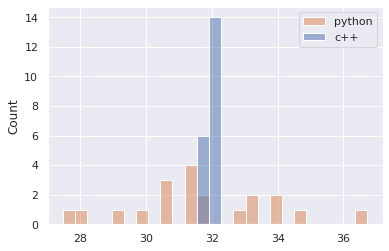

In [82]:
sns.histplot([ests, ests2], legend=True)
plt.legend(labels=["python", "c++"]);

In [80]:
ests

[30.7869,
 28.2914,
 31.1135,
 28.222,
 31.7637,
 30.589,
 28.2847,
 32.0545,
 30.7427,
 31.7221,
 27.8919,
 32.0626,
 27.9084,
 27.772,
 28.9153,
 31.061,
 31.7656,
 27.8301,
 27.9031,
 27.7995]

In [16]:
print(cpp_input)

3 1 1 1
3 2 3
0 1 2
1 1 1
1 1 1
0 1
0 0 2
1 1 0
2 0 1


In [78]:
data = [rand_nfa.bruteforce_count_only(i) for i in range(26)]

In [81]:
[data[i+1] / data[i] for i in range(1, 25)]

[2.0,
 3.5,
 2.142857142857143,
 1.8666666666666667,
 2.0,
 1.9821428571428572,
 1.954954954954955,
 1.9631336405529953,
 1.9671361502347418,
 1.9665871121718377,
 1.9660194174757282,
 1.9657407407407408,
 1.965928717224054,
 1.9659771583739318,
 1.9659571010724732,
 1.965946191676654,
 1.9659449232709691,
 1.9659484602224122,
 1.965948802184324,
 1.9659483110412075,
 1.9659481587913195,
 1.9659481928633655,
 1.9659482494953409,
 1.9659482458453843]

In [82]:
data

[0,
 1,
 2,
 7,
 15,
 28,
 56,
 111,
 217,
 426,
 838,
 1648,
 3240,
 6369,
 12521,
 24616,
 48394,
 95140,
 187040,
 367711,
 722901,
 1421186,
 2793978,
 5492816,
 10798592,
 21229473]

In [85]:
print(rand_nfa.to_text())

6 2 20
0 1 2 3 4 5
0 0 0 1 0 1
1 0 0 0 1 0
0 1
0 0 4
0 0 2
0 1 4
0 1 0
1 1 5
1 1 0
2 0 1
2 0 3
2 1 2
2 1 1
2 1 3
3 0 4
3 0 1
4 1 5
4 1 1
4 1 3
5 0 0
5 0 1
5 0 3
5 1 2


In [86]:
rand_matrix

array([[0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0]])

In [23]:
count_nfa(rand_nfa, 5)

Retries per sample 342955
Sample size 130
1 defaultdict(<class 'collections.Counter'>, {('0', 0): {'': 130}, ('2', 0): {'': 130}}) {('0', 0): 1, ('2', 0): 1}
2 defaultdict(<class 'collections.Counter'>, {('0', 0): {'': 130}, ('2', 0): {'': 130}, ('1', 1): Counter({'0': 73, '1': 57}), ('4', 1): Counter({'1': 66, '0': 64}), ('5', 1): Counter({'1': 130}), ('3', 1): Counter({'1': 130}), ('0', 1): Counter({'1': 72, '0': 58})}) {('0', 0): 1, ('2', 0): 1, ('1', 1): 2, ('4', 1): 2, ('5', 1): 1, ('3', 1): 1, ('0', 1): 2}
3 defaultdict(<class 'collections.Counter'>, {('0', 0): {'': 130}, ('2', 0): {'': 130}, ('1', 1): Counter({'0': 73, '1': 57}), ('4', 1): Counter({'1': 66, '0': 64}), ('5', 1): Counter({'1': 130}), ('3', 1): Counter({'1': 130}), ('0', 1): Counter({'1': 72, '0': 58}), ('1', 2): Counter({'01': 69, '11': 61}), ('5', 2): Counter({'01': 66, '11': 64}), ('2', 2): Counter({'11': 65, '01': 65}), ('4', 2): Counter({'01': 35, '11': 34, '00': 33, '10': 28}), ('3', 2): Counter({'01': 35, '1

(26.049510129197156, <nfa_lib.NFA at 0x7f92db8a97f0>)

In [24]:
print(cpp_input)

5 1.0 1 1.0
6 2 23
0 1 2 3 4 5
1 0 1 0 0 0
0 0 1 1 0 0
0 1
0 0 4
0 1 0
0 1 5
0 1 1
1 0 0
1 0 3
1 1 4
1 1 5
1 1 2
1 1 3
2 0 0
2 0 1
2 1 4
2 1 3
3 0 0
3 0 3
4 0 0
4 0 3
4 1 0
5 0 4
5 0 3
5 1 5
5 1 1
